In [1]:
from matplotlib import pyplot as plt
from tensorflow import keras
import numpy as np
import umap

data = np.load('/active/myler_p/People/Sur/J-IP/LtaP/ivan-pacbio/data_0.npy')
labels = np.load('/active/myler_p/People/Sur/J-IP/LtaP/ivan-pacbio/labels_0.npy')

x_train = data[:-10000]
y_train = labels[:-10000]
x_test = data[-10000:]
y_test = labels[-10000:]

In [2]:
embedding = umap.UMAP().fit_transform(x_test)

181499 181499


/gpfs/home/asur/.virtual/default-3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../gpfs/home/asur/.virtual/default-3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/gpfs/home/asur/.virtual/default-3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..

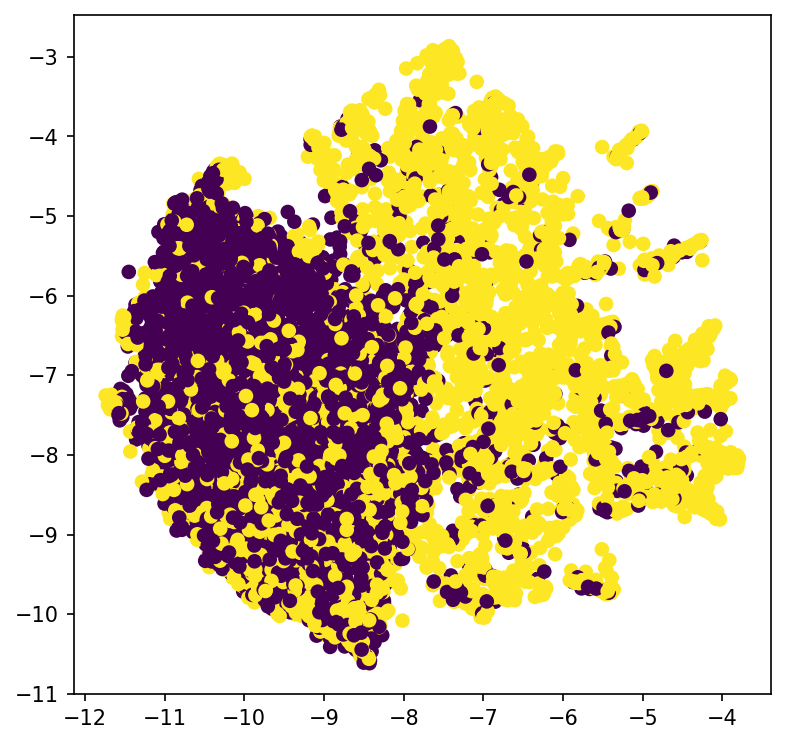

In [3]:
plt.figure(figsize = (6,6), dpi = 150)
plt.scatter(embedding[:, 0], embedding[:, 1], c = y_test)
plt.show()

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(50,  activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=10)

In [ ]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
weights = np.mean(model.get_weights()[0], axis = 1)
start = 0
stop = 51
for i in range(6):
    plt.figure(figsize = (9,4), dpi = 150)
    plt.bar(range(51), weights[start:stop], width = 1)
    plt.show()
    
    start += 51
    stop += 51